In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch

In [27]:
BASE_DIR = "X:/DataSet/Data"
AGG_LEVELS = ["agg_10_minutes", "agg_1_hour", "agg_1_day"]
FOLDERS = ["institutions", "institution_subnets", "ip_addresses_full", "ip_addresses_sample"]

selected_features = [
    "n_flows", "n_packets", "n_bytes", "avg_duration", "tcp_udp_ratio_packets",
    "tcp_udp_ratio_bytes", "dir_ratio_packets", "dir_ratio_bytes",
    "avg_ttl", "n_dest_ports", "n_dest_ip"
]

all_files = []
for folder in FOLDERS:
    for agg in AGG_LEVELS:
        dir_path = os.path.join(BASE_DIR, folder, agg)
        if os.path.exists(dir_path):
            all_files.extend(
                [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".csv")]
            )

# Load subset (~50,000 total files: 45,000 train, 5,000 test)
subset_files = all_files[:50000]

df_list = []
for f in tqdm(subset_files):
    try:
        df = pd.read_csv(f)
        if all(feat in df.columns for feat in selected_features):
            df_list.append(df[selected_features])
    except:
        continue

full_df = pd.concat(df_list, ignore_index=True).dropna()

100%|██████████████████████████████████████████████████████████████████████████████| 5489/5489 [03:17<00:00, 27.83it/s]


In [28]:
full_df['anomaly'] = (full_df['n_flows'] > full_df['n_flows'].quantile(0.99)).astype(int)

X = full_df[selected_features]
y = full_df['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000, train_size=45000, random_state=42)

In [29]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'Isolation Forest': IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    if name == 'Isolation Forest':
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = np.where(y_pred == -1, 1, 0)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        results[name] = {
            'cv_scores': [accuracy_score(y_test, y_pred)],
            'mean': accuracy_score(y_test, y_pred),
            'std': 0.0,
            'report': report,
            'confusion': cm
        }
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {
            'cv_scores': scores,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'report': report,
            'confusion': cm
        }

In [30]:
for name, res in results.items():
    print(f"--- {name} ---")
    if 'cv_scores' in res:
        print("CV Scores:", res['cv_scores'])
    print("Mean Accuracy:", res['mean'])
    print("Std Dev:", res['std'])
    print("Classification Report:")
    print(pd.DataFrame(res['report']).transpose())
    print("Confusion Matrix:")
    print(res['confusion'])
    print("\n")

--- Random Forest ---
CV Scores: [1.         0.99988889 1.         1.         0.99988889]
Mean Accuracy: 0.9999555555555556
Std Dev: 5.443310539515761e-05
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   4945.0
1                   1.0     1.0       1.0     55.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   5000.0
weighted avg        1.0     1.0       1.0   5000.0
Confusion Matrix:
[[4945    0]
 [   0   55]]


--- Decision Tree ---
CV Scores: [1.         0.99988889 1.         1.         0.99977778]
Mean Accuracy: 0.9999333333333335
Std Dev: 8.888888888888835e-05
Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   4945.0
1                   1.0     1.0       1.0     55.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   5000.0
weighted avg        1.0     1.0     

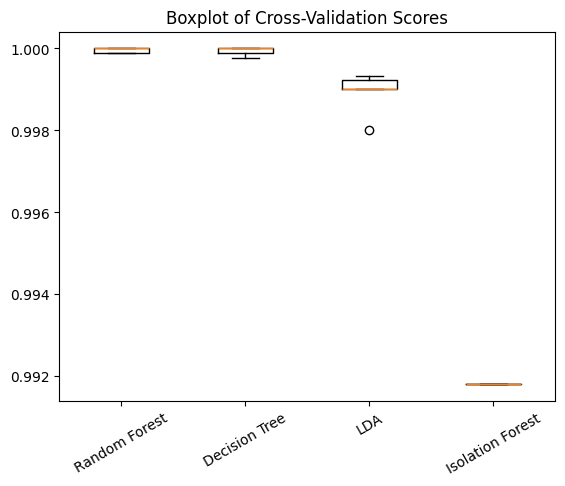

In [31]:
fig, ax = plt.subplots()
box_data = [results[m]['cv_scores'] for m in results.keys() if 'cv_scores' in results[m]]
labels = [m for m in results.keys() if 'cv_scores' in results[m]]
ax.boxplot(box_data, labels=labels)
ax.set_title("Boxplot of Cross-Validation Scores")
plt.xticks(rotation=30)
plt.show()

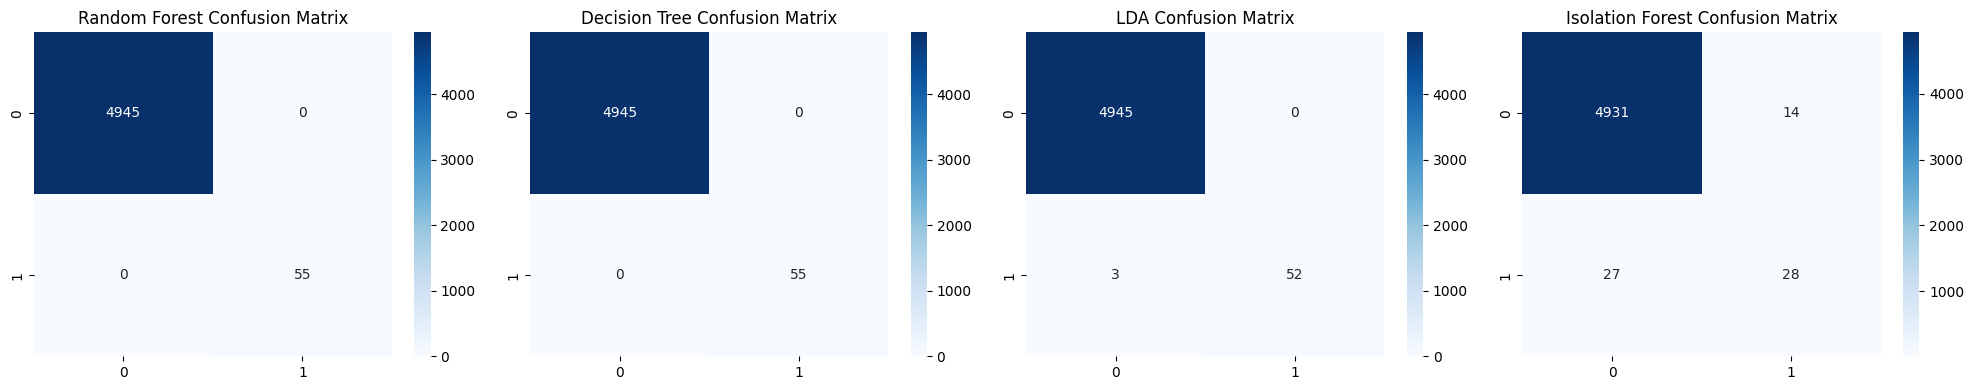

In [32]:
fig, axs = plt.subplots(1, len(results), figsize=(5 * len(results), 4))
for ax, (name, res) in zip(axs, results.items()):
    sns.heatmap(res['confusion'], annot=True, fmt='d', ax=ax, cmap="Blues")
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()